# 独立 ESRGAN (RRDBNet) 训练脚本

本 Notebook 旨在提供一个干净、独立的训练环境，用于在自定义的动漫数据集上微调 ESRGAN 模型。
它直接调用了 APISR 项目中的核心网络架构（RRDBNet, UNetDiscriminatorSN）和损失函数（平衡双感知损失）。

**硬件配置建议 (针对 16GB 显存)：**
* `batch_size`: 8 或 16
* `patch_size`: 256 (HR 图像的裁剪尺寸)
* 开启混合精度训练 (AMP) 以节省显存。

In [1]:
import os
import sys
import glob
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast

# 将本地的 APISR_tools 目录添加到系统路径
apisr_tools_path = os.path.abspath('APISR_tools')
if apisr_tools_path not in sys.path:
    sys.path.append(apisr_tools_path)

# 导入 APISR_tools 中的核心网络和损失函数
from architecture.rrdb import RRDBNet
from architecture.discriminator import UNetDiscriminatorSN
from loss.perceptual_loss import PerceptualLoss
from loss.anime_perceptual_loss import Anime_PerceptualLoss
from loss.gan_loss import GANLoss

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())

PyTorch Version: 2.9.0+cu130
CUDA Available: True


In [2]:
# ==========================================
# 1. 超参数配置 (Hyperparameters)
# ==========================================

# 数据集路径
LR_DIR = 'dataset/lowres/original'
HR_DIR = 'dataset/highres/original'
PRETRAINED_DIR = 'pretrained_models' # 存放预训练权重的文件夹

# 训练参数 (针对 16GB 显存优化)
BATCH_SIZE = 8          # 如果显存充足，可以尝试 16
PATCH_SIZE = 256        # HR 图像的裁剪尺寸 (LR 对应为 64)
SCALE = 4               # 放大倍数
NUM_EPOCHS = 150        # 训练轮数 (微调不需要太多)
LEARNING_RATE = 1e-5    # 初始学习率 (微调时降低，防止破坏预训练权重)
SAVE_FREQ = 10          # 每隔多少个 Epoch 保存一次模型

# 两阶段训练配置 (Two-stage Training)
WARMUP_EPOCHS = 5       # 前 N 个 epoch 只使用 L1 损失 (PSNR-oriented)

# 损失函数权重 (参考 APISR 默认配置并针对微调进行调整)
WEIGHT_PIXEL = 10.0      # 
WEIGHT_VGG = 0.05        # 
WEIGHT_DANBOORU = 0.025   # 
WEIGHT_GAN = 1        #

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# ==========================================
# 2. 数据集定义 (Dataset & DataLoader)
# ==========================================

class AnimeSRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, patch_size=256, scale=4):
        self.lr_paths = sorted(glob.glob(os.path.join(lr_dir, '*.*')))
        self.hr_paths = sorted(glob.glob(os.path.join(hr_dir, '*.*')))
        self.patch_size = patch_size
        self.scale = scale
        
        print(f"数据集加载完成，共 {len(self.lr_paths)} 张 LR 图片和 {len(self.hr_paths)} 张 HR 图片。")
        assert len(self.lr_paths) == len(self.hr_paths), "LR 和 HR 图像数量不匹配！"

    def __len__(self):
        return len(self.hr_paths)

    def __getitem__(self, idx):
        # 读取图像 (BGR -> RGB)
        hr_img = cv2.imread(self.hr_paths[idx])
        lr_img = cv2.imread(self.lr_paths[idx])
        
        if hr_img is None or lr_img is None:
            raise ValueError(f"无法读取图像: {self.hr_paths[idx]} 或 {self.lr_paths[idx]}")
            
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
        lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)

        # 随机裁剪 (Random Crop)
        h_hr, w_hr, _ = hr_img.shape
        h_lr, w_lr, _ = lr_img.shape
        lr_patch_size = self.patch_size // self.scale
        
        # 确保图像足够大
        if h_hr < self.patch_size or w_hr < self.patch_size:
            hr_img = cv2.resize(hr_img, (max(w_hr, self.patch_size), max(h_hr, self.patch_size)))
            lr_img = cv2.resize(lr_img, (max(w_lr, lr_patch_size), max(h_lr, lr_patch_size)))
            h_hr, w_hr, _ = hr_img.shape
            h_lr, w_lr, _ = lr_img.shape

        # 在 LR 上随机选择一个起点
        x_lr = random.randint(0, w_lr - lr_patch_size)
        y_lr = random.randint(0, h_lr - lr_patch_size)
        
        # 计算 HR 上对应的起点
        x_hr = x_lr * self.scale
        y_hr = y_lr * self.scale

        # 裁剪
        hr_patch = hr_img[y_hr:y_hr+self.patch_size, x_hr:x_hr+self.patch_size, :]
        lr_patch = lr_img[y_lr:y_lr+lr_patch_size, x_lr:x_lr+lr_patch_size, :]

        # 数据增强 (随机翻转和旋转)
        if random.random() < 0.5: # 水平翻转
            hr_patch = cv2.flip(hr_patch, 1)
            lr_patch = cv2.flip(lr_patch, 1)
        if random.random() < 0.5: # 垂直翻转
            hr_patch = cv2.flip(hr_patch, 0)
            lr_patch = cv2.flip(lr_patch, 0)
        if random.random() < 0.5: # 90度旋转 (转置)
            hr_patch = hr_patch.transpose(1, 0, 2)
            lr_patch = lr_patch.transpose(1, 0, 2)

        # 转换为 Tensor 并归一化到 [0, 1]
        hr_tensor = torch.from_numpy(hr_patch.transpose(2, 0, 1)).float() / 255.0
        lr_tensor = torch.from_numpy(lr_patch.transpose(2, 0, 1)).float() / 255.0

        return {'lr': lr_tensor, 'hr': hr_tensor}

# 创建 DataLoader
train_dataset = AnimeSRDataset(LR_DIR, HR_DIR, patch_size=PATCH_SIZE, scale=SCALE)
# Windows 下 Jupyter Notebook 多进程容易崩溃，将 num_workers 改为 0
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

print(f"数据集加载完成，共 {len(train_dataset)} 张图片。")

数据集加载完成，共 460 张 LR 图片和 460 张 HR 图片。
数据集加载完成，共 460 张图片。


In [4]:
# ==========================================
# 3. 模型初始化与加载预训练权重 (Model Initialization)
# ==========================================

# 实例化生成器 (RRDBNet)
# APISR 默认使用 23 个 RRDB 块 (num_block=23)
generator = RRDBNet(3, 3, scale=SCALE, num_block=23).to(device)

# 实例化判别器 (UNetDiscriminatorSN)
discriminator = UNetDiscriminatorSN(3).to(device)

# 加载预训练权重 (微调的关键)
pretrained_paths = glob.glob(os.path.join(PRETRAINED_DIR, '*.pth'))
if pretrained_paths:
    # 默认加载找到的第一个 .pth 文件
    pretrained_path = pretrained_paths[0]
    print(f"正在加载预训练模型: {pretrained_path}")
    
    checkpoint = torch.load(pretrained_path, map_location=device)
    
    # 兼容不同格式的权重文件
    if 'params_ema' in checkpoint:
        generator.load_state_dict(checkpoint['params_ema'], strict=False)
    elif 'model_state_dict' in checkpoint:
        generator.load_state_dict(checkpoint['model_state_dict'], strict=False)
    else:
        generator.load_state_dict(checkpoint, strict=False)
        
    print("预训练模型加载成功！")
else:
    print(f"警告: 在 {PRETRAINED_DIR} 中未找到预训练模型 (.pth)。模型将从头开始训练 (不推荐)。")

正在加载预训练模型: pretrained_models\4x_APISR_RRDB_GAN_generator.pth
预训练模型加载成功！


In [5]:
# ==========================================
# 4. 损失函数与优化器 (Losses & Optimizers)
# ==========================================

# 像素损失 (L1 Loss)
cri_pix = nn.L1Loss().to(device)

# 平衡双感知损失 (Balanced Twin Perceptual Loss)
# 1. VGG 感知损失 (维持基本结构)
# 注意：首次运行会自动下载 VGG19 预训练权重
cri_vgg = PerceptualLoss(
    layer_weights={'conv1_2': 0.1, 'conv2_2': 0.1, 'conv3_4': 1, 'conv4_4': 1, 'conv5_4': 1}, # 采用 APISR 默认的 VGG 层权重
    vgg_type='vgg19', 
    perceptual_weight=WEIGHT_VGG
).to(device)

# 2. Danbooru 动漫感知损失 (约束动漫风格)
# 注意：APISR 的 Anime_PerceptualLoss 可能会尝试加载本地的 ResNet 权重
# 如果报错找不到权重，请检查 APISR/pretrained 文件夹或其代码中的下载逻辑
cri_danbooru = Anime_PerceptualLoss(
    layer_weights={"0": 0.1, "4_2_conv3": 20, "5_3_conv3": 25, "6_5_conv3": 1, "7_2_conv3": 1}, 
    perceptual_weight=WEIGHT_DANBOORU
).to(device)

# 对抗损失 (GAN Loss)
# APISR 默认使用 vanilla GAN loss
cri_gan = GANLoss(gan_type="vanilla", loss_weight=WEIGHT_GAN).to(device)

# 优化器 (Adam)
optimizer_g = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))

# 学习率调度器 (每 30 个 epoch 衰减一半)
scheduler_g = optim.lr_scheduler.StepLR(optimizer_g, step_size=30, gamma=0.5)
scheduler_d = optim.lr_scheduler.StepLR(optimizer_d, step_size=30, gamma=0.5)

# 混合精度训练 (AMP) Scaler (使用新 API 避免 FutureWarning)
scaler = torch.amp.GradScaler('cuda')

print("损失函数、优化器和调度器初始化完成。")

c:\Users\admin\.conda\envs\ece284fa25\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\.conda\envs\ece284fa25\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\admin\.conda\envs\ece284fa25\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


损失函数、优化器和调度器初始化完成。


In [6]:
# ==========================================
# 5. 训练主循环 (Training Loop)
# ==========================================

# 创建保存模型的文件夹
os.makedirs('saved_models', exist_ok=True)

# 开跑前检查：确保数据集路径存在，避免训练到一半报错
assert os.path.isdir(LR_DIR), f"LR 数据集路径不存在: {LR_DIR}"
assert os.path.isdir(HR_DIR), f"HR 数据集路径不存在: {HR_DIR}"
print("开始训练...")
best_loss = float('inf')
history_loss_g = []
history_loss_d = []

for epoch in range(NUM_EPOCHS):
    generator.train()
    discriminator.train()
    
    epoch_loss_g = 0.0
    epoch_loss_d = 0.0
    
    # 学习率调度：从第 2 个 epoch 开始，在 epoch 开始时更新 (符合 optimizer.step() 后再 scheduler.step() 的推荐顺序，避免警告)
    if epoch > 0:
        scheduler_g.step()
        scheduler_d.step()
        for opt in [optimizer_g, optimizer_d]:
            for pg in opt.param_groups:
                pg["lr"] = max(pg["lr"], 1e-6)
    
    # 判断当前是否处于 Warmup 阶段 (只使用 L1 损失)
    is_warmup = epoch < WARMUP_EPOCHS
    if is_warmup:
        print(f"--- Epoch {epoch+1}: Warmup Phase (L1 Loss Only) ---")
    else:
        print(f"--- Epoch {epoch+1}: GAN Phase (L1 + Perceptual + GAN) ---")
    
    # 使用 tqdm 显示进度条
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    
    for batch_idx, batch in enumerate(pbar):
        imgs_lr = batch['lr'].to(device)
        imgs_hr = batch['hr'].to(device)
        
        # -----------------------------------------------------------
        # 1. 训练生成器 (Train Generator)
        # -----------------------------------------------------------
        optimizer_g.zero_grad()
        
        # 冻结判别器参数，避免在训练生成器时计算判别器的梯度
        for p in discriminator.parameters():
            p.requires_grad = False
            
        with torch.amp.autocast('cuda'): # 开启混合精度 (新版 API)
            # 生成假的高清图
            gen_hr = generator(imgs_lr)
            
            # 计算像素损失 (L1)
            l_g_pix = cri_pix(gen_hr, imgs_hr) * WEIGHT_PIXEL
            
            if is_warmup:
                # Warmup 阶段：只使用 L1 损失
                loss_g = l_g_pix
                l_g_percep = torch.tensor(0.0, device=device)
                l_g_gan = torch.tensor(0.0, device=device)
            else:
                # GAN 阶段：计算平衡双感知损失 (Twin Perceptual Loss)
                l_g_percep_vgg = cri_vgg(gen_hr, imgs_hr)
                l_g_percep_danbooru = cri_danbooru(gen_hr, imgs_hr)
                l_g_percep = l_g_percep_vgg + l_g_percep_danbooru
                
                # 计算对抗损失 (GAN Loss)
                # 判别器对生成图的预测
                fake_g_preds = discriminator(gen_hr)
                # 生成器希望判别器认为它是真的 (True)
                l_g_gan = cri_gan(fake_g_preds, True, is_disc=False)
                
                # 总生成器损失
                loss_g = l_g_pix + l_g_percep + l_g_gan
            
        # 反向传播和优化
        scaler.scale(loss_g).backward()
        scaler.step(optimizer_g)
        scaler.update()
        
        epoch_loss_g += loss_g.item()
        
        # -----------------------------------------------------------
        # 2. 训练判别器 (Train Discriminator)
        # -----------------------------------------------------------
        if not is_warmup:
            # 只有在 GAN 阶段才训练判别器
            # 解冻判别器参数
            for p in discriminator.parameters():
                p.requires_grad = True
                
            optimizer_d.zero_grad()
            
            with torch.amp.autocast('cuda'): # 开启混合精度 (新版 API)
                # 判别器对真实图的预测 (Real)
                # 注意：这里我们直接用干净的 HR 作为 Real 样本。
                # 如果你想完全复刻 APISR，这里应该用带有轻微退化的 degrade_hr。
                real_d_preds = discriminator(imgs_hr)
                l_d_real = cri_gan(real_d_preds, True, is_disc=True)
                
                # 判别器对生成图的预测 (Fake)
                # 使用 .detach() 避免梯度传回生成器
                fake_d_preds = discriminator(gen_hr.detach())
                l_d_fake = cri_gan(fake_d_preds, False, is_disc=True)
                
                # 总判别器损失
                loss_d = l_d_real + l_d_fake
                
            # 反向传播和优化
            scaler.scale(loss_d).backward()
            scaler.step(optimizer_d)
            scaler.update()
            
            epoch_loss_d += loss_d.item()
        else:
            # Warmup 阶段判别器损失为 0
            loss_d = torch.tensor(0.0, device=device)
        
        # 更新进度条显示
        pbar.set_postfix({
            'Loss_G': f"{loss_g.item():.4f}", 
            'Loss_D': f"{loss_d.item():.4f}",
            'L1': f"{l_g_pix.item():.4f}",
            'Percep': f"{l_g_percep.item():.4f}",
            'GAN': f"{l_g_gan.item():.4f}"
        })
        
    # -----------------------------------------------------------
    # 3. Epoch 结束后的操作 (保存模型、记录损失、更新学习率)
    # -----------------------------------------------------------
    avg_loss_g = epoch_loss_g / len(train_loader)
    avg_loss_d = epoch_loss_d / len(train_loader) if not is_warmup else 0.0
    
    history_loss_g.append(avg_loss_g)
    history_loss_d.append(avg_loss_d)
    
    current_lr = optimizer_g.param_groups[0]["lr"]
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] 结束. 平均 Loss_G: {avg_loss_g:.4f}, 平均 Loss_D: {avg_loss_d:.4f}, LR: {current_lr:.6f}")
    
    # 保存 Best Model (基于生成器损失)
    if avg_loss_g < best_loss and not is_warmup: # 只有在 GAN 阶段才考虑保存 Best Model
        best_loss = avg_loss_g
        best_save_path = "saved_models/esrgan_finetune_best.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': optimizer_g.state_dict(),
            'loss': avg_loss_g,
        }, best_save_path)
        print(f"--> 发现更低损失，已保存 Best Model 至: {best_save_path}")
    
    # 定期保存模型
    if (epoch + 1) % SAVE_FREQ == 0 or (epoch + 1) == NUM_EPOCHS:
        save_path = f"saved_models/esrgan_finetune_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': optimizer_g.state_dict(),
            'loss': avg_loss_g,
        }, save_path)
        print(f"--> 模型已定期保存至: {save_path}")
        
print("训练完成！")

开始训练...
--- Epoch 1: Warmup Phase (L1 Loss Only) ---


Epoch [1/150]: 100%|██████████| 58/58 [01:23<00:00,  1.44s/it, Loss_G=4.6746, Loss_D=0.0000, L1=4.6746, Percep=0.0000, GAN=0.0000]  
c:\Users\admin\.conda\envs\ece284fa25\Lib\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch [1/150] 结束. 平均 Loss_G: 11.3384, 平均 Loss_D: 0.0000, LR: 0.000010
--- Epoch 2: Warmup Phase (L1 Loss Only) ---


Epoch [2/150]: 100%|██████████| 58/58 [01:12<00:00,  1.25s/it, Loss_G=1.6251, Loss_D=0.0000, L1=1.6251, Percep=0.0000, GAN=0.0000]


Epoch [2/150] 结束. 平均 Loss_G: 3.1386, 平均 Loss_D: 0.0000, LR: 0.000010
--- Epoch 3: Warmup Phase (L1 Loss Only) ---


Epoch [3/150]: 100%|██████████| 58/58 [01:12<00:00,  1.25s/it, Loss_G=1.0253, Loss_D=0.0000, L1=1.0253, Percep=0.0000, GAN=0.0000]


Epoch [3/150] 结束. 平均 Loss_G: 1.3216, 平均 Loss_D: 0.0000, LR: 0.000010
--- Epoch 4: Warmup Phase (L1 Loss Only) ---


Epoch [4/150]: 100%|██████████| 58/58 [01:12<00:00,  1.25s/it, Loss_G=0.7344, Loss_D=0.0000, L1=0.7344, Percep=0.0000, GAN=0.0000]


Epoch [4/150] 结束. 平均 Loss_G: 0.8852, 平均 Loss_D: 0.0000, LR: 0.000010
--- Epoch 5: Warmup Phase (L1 Loss Only) ---


Epoch [5/150]: 100%|██████████| 58/58 [01:12<00:00,  1.25s/it, Loss_G=0.8802, Loss_D=0.0000, L1=0.8802, Percep=0.0000, GAN=0.0000]


Epoch [5/150] 结束. 平均 Loss_G: 0.7658, 平均 Loss_D: 0.0000, LR: 0.000010
--- Epoch 6: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [6/150]: 100%|██████████| 58/58 [01:28<00:00,  1.53s/it, Loss_G=2.1473, Loss_D=1.3855, L1=0.7157, Percep=0.7436, GAN=0.6880]


Epoch [6/150] 结束. 平均 Loss_G: 2.1911, 平均 Loss_D: 1.3860, LR: 0.000010
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--- Epoch 7: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [7/150]: 100%|██████████| 58/58 [01:26<00:00,  1.49s/it, Loss_G=1.9131, Loss_D=1.3664, L1=0.6042, Percep=0.6361, GAN=0.6728]


Epoch [7/150] 结束. 平均 Loss_G: 2.0524, 平均 Loss_D: 1.3798, LR: 0.000010
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--- Epoch 8: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [8/150]: 100%|██████████| 58/58 [01:26<00:00,  1.49s/it, Loss_G=1.7230, Loss_D=1.3573, L1=0.4418, Percep=0.4984, GAN=0.7828]


Epoch [8/150] 结束. 平均 Loss_G: 2.0340, 平均 Loss_D: 1.3575, LR: 0.000010
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--- Epoch 9: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [9/150]: 100%|██████████| 58/58 [01:26<00:00,  1.49s/it, Loss_G=2.6209, Loss_D=1.2709, L1=0.6684, Percep=0.8358, GAN=1.1167]


Epoch [9/150] 结束. 平均 Loss_G: 2.0430, 平均 Loss_D: 1.3239, LR: 0.000010
--- Epoch 10: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [10/150]: 100%|██████████| 58/58 [01:26<00:00,  1.49s/it, Loss_G=2.0537, Loss_D=1.2305, L1=0.5864, Percep=0.7240, GAN=0.7433]


Epoch [10/150] 结束. 平均 Loss_G: 1.9965, 平均 Loss_D: 1.3089, LR: 0.000010
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--> 模型已定期保存至: saved_models/esrgan_finetune_epoch_10.pth
--- Epoch 11: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [11/150]: 100%|██████████| 58/58 [01:26<00:00,  1.49s/it, Loss_G=2.0170, Loss_D=1.2460, L1=0.5524, Percep=0.6690, GAN=0.7956]


Epoch [11/150] 结束. 平均 Loss_G: 1.9479, 平均 Loss_D: 1.2978, LR: 0.000010
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--- Epoch 12: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [12/150]: 100%|██████████| 58/58 [01:26<00:00,  1.49s/it, Loss_G=2.3918, Loss_D=1.1947, L1=0.7200, Percep=0.9399, GAN=0.7319]


Epoch [12/150] 结束. 平均 Loss_G: 2.0103, 平均 Loss_D: 1.2820, LR: 0.000010
--- Epoch 13: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [13/150]: 100%|██████████| 58/58 [01:26<00:00,  1.49s/it, Loss_G=1.7937, Loss_D=1.4160, L1=0.3653, Percep=0.4640, GAN=0.9644]


Epoch [13/150] 结束. 平均 Loss_G: 2.0162, 平均 Loss_D: 1.2794, LR: 0.000010
--- Epoch 14: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [14/150]: 100%|██████████| 58/58 [01:26<00:00,  1.48s/it, Loss_G=2.0245, Loss_D=1.2524, L1=0.5911, Percep=0.8032, GAN=0.6301]


Epoch [14/150] 结束. 平均 Loss_G: 1.9879, 平均 Loss_D: 1.2908, LR: 0.000010
--- Epoch 15: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [15/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9140, Loss_D=1.2480, L1=0.4631, Percep=0.5776, GAN=0.8733]


Epoch [15/150] 结束. 平均 Loss_G: 1.9521, 平均 Loss_D: 1.2778, LR: 0.000010
--- Epoch 16: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [16/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6617, Loss_D=1.3325, L1=0.3815, Percep=0.5097, GAN=0.7705]


Epoch [16/150] 结束. 平均 Loss_G: 1.9681, 平均 Loss_D: 1.2793, LR: 0.000010
--- Epoch 17: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [17/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9470, Loss_D=1.1918, L1=0.6093, Percep=0.7285, GAN=0.6092]


Epoch [17/150] 结束. 平均 Loss_G: 1.9104, 平均 Loss_D: 1.2780, LR: 0.000010
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--- Epoch 18: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [18/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=2.3836, Loss_D=1.2449, L1=0.6153, Percep=0.8426, GAN=0.9258]


Epoch [18/150] 结束. 平均 Loss_G: 1.9209, 平均 Loss_D: 1.2677, LR: 0.000010
--- Epoch 19: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [19/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6121, Loss_D=1.3784, L1=0.3322, Percep=0.5155, GAN=0.7644]


Epoch [19/150] 结束. 平均 Loss_G: 1.9497, 平均 Loss_D: 1.2557, LR: 0.000010
--- Epoch 20: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [20/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=2.0875, Loss_D=1.3327, L1=0.4373, Percep=0.6505, GAN=0.9998]


Epoch [20/150] 结束. 平均 Loss_G: 1.8662, 平均 Loss_D: 1.2782, LR: 0.000010
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--> 模型已定期保存至: saved_models/esrgan_finetune_epoch_20.pth
--- Epoch 21: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [21/150]: 100%|██████████| 58/58 [01:26<00:00,  1.48s/it, Loss_G=2.2562, Loss_D=1.1549, L1=0.6433, Percep=0.8620, GAN=0.7509]


Epoch [21/150] 结束. 平均 Loss_G: 1.9009, 平均 Loss_D: 1.2711, LR: 0.000010
--- Epoch 22: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [22/150]: 100%|██████████| 58/58 [01:26<00:00,  1.49s/it, Loss_G=1.5880, Loss_D=1.3500, L1=0.3737, Percep=0.4985, GAN=0.7159]


Epoch [22/150] 结束. 平均 Loss_G: 1.8934, 平均 Loss_D: 1.2896, LR: 0.000010
--- Epoch 23: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [23/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.5596, Loss_D=1.3644, L1=0.3363, Percep=0.4584, GAN=0.7650]


Epoch [23/150] 结束. 平均 Loss_G: 1.8929, 平均 Loss_D: 1.2996, LR: 0.000010
--- Epoch 24: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [24/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9645, Loss_D=1.2911, L1=0.4478, Percep=0.6313, GAN=0.8854]


Epoch [24/150] 结束. 平均 Loss_G: 1.8754, 平均 Loss_D: 1.3010, LR: 0.000010
--- Epoch 25: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [25/150]: 100%|██████████| 58/58 [01:26<00:00,  1.48s/it, Loss_G=1.7481, Loss_D=1.2542, L1=0.4285, Percep=0.6010, GAN=0.7186]


Epoch [25/150] 结束. 平均 Loss_G: 1.8444, 平均 Loss_D: 1.3030, LR: 0.000010
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--- Epoch 26: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [26/150]: 100%|██████████| 58/58 [01:26<00:00,  1.48s/it, Loss_G=1.4221, Loss_D=1.3299, L1=0.2983, Percep=0.4188, GAN=0.7051]


Epoch [26/150] 结束. 平均 Loss_G: 1.8405, 平均 Loss_D: 1.3076, LR: 0.000010
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--- Epoch 27: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [27/150]: 100%|██████████| 58/58 [01:26<00:00,  1.48s/it, Loss_G=1.6876, Loss_D=1.3470, L1=0.3807, Percep=0.4947, GAN=0.8121]


Epoch [27/150] 结束. 平均 Loss_G: 1.8163, 平均 Loss_D: 1.3232, LR: 0.000010
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--- Epoch 28: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [28/150]: 100%|██████████| 58/58 [01:26<00:00,  1.49s/it, Loss_G=1.9305, Loss_D=1.2333, L1=0.5097, Percep=0.7186, GAN=0.7022]


Epoch [28/150] 结束. 平均 Loss_G: 1.8305, 平均 Loss_D: 1.3231, LR: 0.000010
--- Epoch 29: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [29/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=2.1813, Loss_D=1.2977, L1=0.6340, Percep=0.7484, GAN=0.7989]


Epoch [29/150] 结束. 平均 Loss_G: 1.8286, 平均 Loss_D: 1.3178, LR: 0.000010
--- Epoch 30: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [30/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.4462, Loss_D=1.3546, L1=0.2953, Percep=0.4474, GAN=0.7036]


Epoch [30/150] 结束. 平均 Loss_G: 1.8087, 平均 Loss_D: 1.3208, LR: 0.000010
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--> 模型已定期保存至: saved_models/esrgan_finetune_epoch_30.pth
--- Epoch 31: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [31/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.8267, Loss_D=1.3068, L1=0.4332, Percep=0.6023, GAN=0.7912]


Epoch [31/150] 结束. 平均 Loss_G: 1.7835, 平均 Loss_D: 1.3121, LR: 0.000005
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--- Epoch 32: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [32/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6481, Loss_D=1.3698, L1=0.3325, Percep=0.5848, GAN=0.7309]


Epoch [32/150] 结束. 平均 Loss_G: 1.8151, 平均 Loss_D: 1.3084, LR: 0.000005
--- Epoch 33: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [33/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.4987, Loss_D=1.3644, L1=0.2655, Percep=0.4385, GAN=0.7948]


Epoch [33/150] 结束. 平均 Loss_G: 1.7914, 平均 Loss_D: 1.3183, LR: 0.000005
--- Epoch 34: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [34/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9692, Loss_D=1.3452, L1=0.5249, Percep=0.6894, GAN=0.7550]


Epoch [34/150] 结束. 平均 Loss_G: 1.7924, 平均 Loss_D: 1.3203, LR: 0.000005
--- Epoch 35: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [35/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.5316, Loss_D=1.3683, L1=0.2668, Percep=0.4863, GAN=0.7785]


Epoch [35/150] 结束. 平均 Loss_G: 1.8212, 平均 Loss_D: 1.3216, LR: 0.000005
--- Epoch 36: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [36/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.5159, Loss_D=1.3951, L1=0.3959, Percep=0.4974, GAN=0.6226]


Epoch [36/150] 结束. 平均 Loss_G: 1.8037, 平均 Loss_D: 1.3253, LR: 0.000005
--- Epoch 37: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [37/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6535, Loss_D=1.3497, L1=0.3181, Percep=0.5042, GAN=0.8312]


Epoch [37/150] 结束. 平均 Loss_G: 1.7617, 平均 Loss_D: 1.3203, LR: 0.000005
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--- Epoch 38: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [38/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9838, Loss_D=1.2889, L1=0.5065, Percep=0.7055, GAN=0.7718]


Epoch [38/150] 结束. 平均 Loss_G: 1.7866, 平均 Loss_D: 1.3135, LR: 0.000005
--- Epoch 39: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [39/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.5876, Loss_D=1.2483, L1=0.3596, Percep=0.4868, GAN=0.7412]


Epoch [39/150] 结束. 平均 Loss_G: 1.7925, 平均 Loss_D: 1.3212, LR: 0.000005
--- Epoch 40: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [40/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=2.3514, Loss_D=1.2578, L1=0.6554, Percep=0.8473, GAN=0.8487]


Epoch [40/150] 结束. 平均 Loss_G: 1.8212, 平均 Loss_D: 1.3260, LR: 0.000005
--> 模型已定期保存至: saved_models/esrgan_finetune_epoch_40.pth
--- Epoch 41: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [41/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.5508, Loss_D=1.3619, L1=0.3287, Percep=0.5038, GAN=0.7182]


Epoch [41/150] 结束. 平均 Loss_G: 1.7805, 平均 Loss_D: 1.3322, LR: 0.000005
--- Epoch 42: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [42/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.8195, Loss_D=1.2087, L1=0.4044, Percep=0.5769, GAN=0.8382]


Epoch [42/150] 结束. 平均 Loss_G: 1.8154, 平均 Loss_D: 1.3092, LR: 0.000005
--- Epoch 43: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [43/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7094, Loss_D=1.3385, L1=0.3531, Percep=0.5740, GAN=0.7823]


Epoch [43/150] 结束. 平均 Loss_G: 1.7809, 平均 Loss_D: 1.3244, LR: 0.000005
--- Epoch 44: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [44/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.5801, Loss_D=1.3781, L1=0.3319, Percep=0.4795, GAN=0.7687]


Epoch [44/150] 结束. 平均 Loss_G: 1.8109, 平均 Loss_D: 1.3192, LR: 0.000005
--- Epoch 45: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [45/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9381, Loss_D=1.3165, L1=0.4900, Percep=0.6583, GAN=0.7898]


Epoch [45/150] 结束. 平均 Loss_G: 1.8036, 平均 Loss_D: 1.3171, LR: 0.000005
--- Epoch 46: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [46/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7661, Loss_D=1.3639, L1=0.3596, Percep=0.5718, GAN=0.8347]


Epoch [46/150] 结束. 平均 Loss_G: 1.7948, 平均 Loss_D: 1.3194, LR: 0.000005
--- Epoch 47: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [47/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9483, Loss_D=1.1541, L1=0.5846, Percep=0.6868, GAN=0.6770]


Epoch [47/150] 结束. 平均 Loss_G: 1.7949, 平均 Loss_D: 1.3143, LR: 0.000005
--- Epoch 48: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [48/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9949, Loss_D=1.2446, L1=0.5578, Percep=0.6711, GAN=0.7659]


Epoch [48/150] 结束. 平均 Loss_G: 1.7910, 平均 Loss_D: 1.3161, LR: 0.000005
--- Epoch 49: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [49/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6397, Loss_D=1.3948, L1=0.4025, Percep=0.5834, GAN=0.6537]


Epoch [49/150] 结束. 平均 Loss_G: 1.7632, 平均 Loss_D: 1.3255, LR: 0.000005
--- Epoch 50: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [50/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=2.0830, Loss_D=1.2365, L1=0.6004, Percep=0.7393, GAN=0.7433]


Epoch [50/150] 结束. 平均 Loss_G: 1.7808, 平均 Loss_D: 1.3130, LR: 0.000005
--> 模型已定期保存至: saved_models/esrgan_finetune_epoch_50.pth
--- Epoch 51: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [51/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9466, Loss_D=1.2446, L1=0.5276, Percep=0.7208, GAN=0.6982]


Epoch [51/150] 结束. 平均 Loss_G: 1.7648, 平均 Loss_D: 1.3194, LR: 0.000005
--- Epoch 52: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [52/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6779, Loss_D=1.3595, L1=0.3334, Percep=0.4997, GAN=0.8449]


Epoch [52/150] 结束. 平均 Loss_G: 1.7930, 平均 Loss_D: 1.3178, LR: 0.000005
--- Epoch 53: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [53/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7835, Loss_D=1.3455, L1=0.4812, Percep=0.6111, GAN=0.6912]


Epoch [53/150] 结束. 平均 Loss_G: 1.8067, 平均 Loss_D: 1.3195, LR: 0.000005
--- Epoch 54: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [54/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.5842, Loss_D=1.2551, L1=0.3708, Percep=0.4823, GAN=0.7312]


Epoch [54/150] 结束. 平均 Loss_G: 1.7621, 平均 Loss_D: 1.3107, LR: 0.000005
--- Epoch 55: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [55/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.5299, Loss_D=1.3863, L1=0.2296, Percep=0.4164, GAN=0.8838]


Epoch [55/150] 结束. 平均 Loss_G: 1.7963, 平均 Loss_D: 1.3194, LR: 0.000005
--- Epoch 56: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [56/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=2.2360, Loss_D=1.2824, L1=0.6760, Percep=0.7599, GAN=0.8001]


Epoch [56/150] 结束. 平均 Loss_G: 1.7509, 平均 Loss_D: 1.3092, LR: 0.000005
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--- Epoch 57: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [57/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9138, Loss_D=1.3292, L1=0.4666, Percep=0.6386, GAN=0.8085]


Epoch [57/150] 结束. 平均 Loss_G: 1.7531, 平均 Loss_D: 1.3130, LR: 0.000005
--- Epoch 58: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [58/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.4486, Loss_D=1.4148, L1=0.2484, Percep=0.3978, GAN=0.8024]


Epoch [58/150] 结束. 平均 Loss_G: 1.7708, 平均 Loss_D: 1.3119, LR: 0.000005
--- Epoch 59: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [59/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7792, Loss_D=1.1575, L1=0.4979, Percep=0.5789, GAN=0.7023]


Epoch [59/150] 结束. 平均 Loss_G: 1.7694, 平均 Loss_D: 1.3053, LR: 0.000005
--- Epoch 60: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [60/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.5103, Loss_D=1.3756, L1=0.2426, Percep=0.3921, GAN=0.8756]


Epoch [60/150] 结束. 平均 Loss_G: 1.7323, 平均 Loss_D: 1.3174, LR: 0.000005
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--> 模型已定期保存至: saved_models/esrgan_finetune_epoch_60.pth
--- Epoch 61: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [61/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.4427, Loss_D=1.3618, L1=0.2604, Percep=0.4219, GAN=0.7603]


Epoch [61/150] 结束. 平均 Loss_G: 1.7588, 平均 Loss_D: 1.3127, LR: 0.000003
--- Epoch 62: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [62/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.4281, Loss_D=1.3748, L1=0.2102, Percep=0.3887, GAN=0.8292]


Epoch [62/150] 结束. 平均 Loss_G: 1.7467, 平均 Loss_D: 1.2978, LR: 0.000003
--- Epoch 63: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [63/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=2.1168, Loss_D=1.2339, L1=0.5603, Percep=0.7953, GAN=0.7613]


Epoch [63/150] 结束. 平均 Loss_G: 1.7695, 平均 Loss_D: 1.2933, LR: 0.000003
--- Epoch 64: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [64/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.3286, Loss_D=1.4162, L1=0.1791, Percep=0.3113, GAN=0.8382]


Epoch [64/150] 结束. 平均 Loss_G: 1.7972, 平均 Loss_D: 1.3016, LR: 0.000003
--- Epoch 65: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [65/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.3392, Loss_D=1.3487, L1=0.2268, Percep=0.4472, GAN=0.6652]


Epoch [65/150] 结束. 平均 Loss_G: 1.7388, 平均 Loss_D: 1.3033, LR: 0.000003
--- Epoch 66: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [66/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=2.1487, Loss_D=1.1674, L1=0.6117, Percep=0.7863, GAN=0.7507]


Epoch [66/150] 结束. 平均 Loss_G: 1.7627, 平均 Loss_D: 1.2939, LR: 0.000003
--- Epoch 67: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [67/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.5939, Loss_D=1.2449, L1=0.3367, Percep=0.5787, GAN=0.6785]


Epoch [67/150] 结束. 平均 Loss_G: 1.7797, 平均 Loss_D: 1.2979, LR: 0.000003
--- Epoch 68: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [68/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=2.1824, Loss_D=1.2402, L1=0.5048, Percep=0.8026, GAN=0.8750]


Epoch [68/150] 结束. 平均 Loss_G: 1.7569, 平均 Loss_D: 1.3049, LR: 0.000003
--- Epoch 69: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [69/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.8664, Loss_D=1.3480, L1=0.4469, Percep=0.6156, GAN=0.8038]


Epoch [69/150] 结束. 平均 Loss_G: 1.7321, 平均 Loss_D: 1.2926, LR: 0.000003
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--- Epoch 70: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [70/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=2.1763, Loss_D=1.1307, L1=0.5778, Percep=0.6833, GAN=0.9152]


Epoch [70/150] 结束. 平均 Loss_G: 1.7906, 平均 Loss_D: 1.3026, LR: 0.000003
--> 模型已定期保存至: saved_models/esrgan_finetune_epoch_70.pth
--- Epoch 71: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [71/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9969, Loss_D=1.1649, L1=0.5394, Percep=0.7075, GAN=0.7500]


Epoch [71/150] 结束. 平均 Loss_G: 1.7656, 平均 Loss_D: 1.2951, LR: 0.000003
--- Epoch 72: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [72/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6602, Loss_D=1.3395, L1=0.3154, Percep=0.5040, GAN=0.8408]


Epoch [72/150] 结束. 平均 Loss_G: 1.7621, 平均 Loss_D: 1.2915, LR: 0.000003
--- Epoch 73: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [73/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6680, Loss_D=1.3916, L1=0.3376, Percep=0.5131, GAN=0.8173]


Epoch [73/150] 结束. 平均 Loss_G: 1.7540, 平均 Loss_D: 1.2992, LR: 0.000003
--- Epoch 74: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [74/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6352, Loss_D=1.3651, L1=0.2992, Percep=0.4990, GAN=0.8370]


Epoch [74/150] 结束. 平均 Loss_G: 1.7848, 平均 Loss_D: 1.2902, LR: 0.000003
--- Epoch 75: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [75/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7646, Loss_D=1.2266, L1=0.4143, Percep=0.6177, GAN=0.7326]


Epoch [75/150] 结束. 平均 Loss_G: 1.7554, 平均 Loss_D: 1.2974, LR: 0.000003
--- Epoch 76: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [76/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.8904, Loss_D=1.3222, L1=0.5184, Percep=0.6918, GAN=0.6801]


Epoch [76/150] 结束. 平均 Loss_G: 1.7623, 平均 Loss_D: 1.2961, LR: 0.000003
--- Epoch 77: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [77/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.8977, Loss_D=1.3280, L1=0.3780, Percep=0.5962, GAN=0.9235]


Epoch [77/150] 结束. 平均 Loss_G: 1.7529, 平均 Loss_D: 1.2949, LR: 0.000003
--- Epoch 78: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [78/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6608, Loss_D=1.3022, L1=0.4205, Percep=0.6074, GAN=0.6330]


Epoch [78/150] 结束. 平均 Loss_G: 1.7848, 平均 Loss_D: 1.3111, LR: 0.000003
--- Epoch 79: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [79/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=2.0544, Loss_D=1.1369, L1=0.5441, Percep=0.7705, GAN=0.7397]


Epoch [79/150] 结束. 平均 Loss_G: 1.7421, 平均 Loss_D: 1.2938, LR: 0.000003
--- Epoch 80: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [80/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9597, Loss_D=1.2914, L1=0.4494, Percep=0.6636, GAN=0.8467]


Epoch [80/150] 结束. 平均 Loss_G: 1.7700, 平均 Loss_D: 1.3016, LR: 0.000003
--> 模型已定期保存至: saved_models/esrgan_finetune_epoch_80.pth
--- Epoch 81: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [81/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.3773, Loss_D=1.3363, L1=0.2363, Percep=0.4254, GAN=0.7155]


Epoch [81/150] 结束. 平均 Loss_G: 1.7271, 平均 Loss_D: 1.2991, LR: 0.000003
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--- Epoch 82: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [82/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.8434, Loss_D=1.2669, L1=0.4212, Percep=0.6373, GAN=0.7849]


Epoch [82/150] 结束. 平均 Loss_G: 1.7674, 平均 Loss_D: 1.2946, LR: 0.000003
--- Epoch 83: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [83/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.8251, Loss_D=1.3417, L1=0.4929, Percep=0.6755, GAN=0.6567]


Epoch [83/150] 结束. 平均 Loss_G: 1.7447, 平均 Loss_D: 1.3035, LR: 0.000003
--- Epoch 84: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [84/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6612, Loss_D=1.2822, L1=0.3709, Percep=0.5516, GAN=0.7387]


Epoch [84/150] 结束. 平均 Loss_G: 1.7914, 平均 Loss_D: 1.2922, LR: 0.000003
--- Epoch 85: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [85/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7352, Loss_D=1.2781, L1=0.3324, Percep=0.5956, GAN=0.8072]


Epoch [85/150] 结束. 平均 Loss_G: 1.7730, 平均 Loss_D: 1.3041, LR: 0.000003
--- Epoch 86: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [86/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9627, Loss_D=1.2495, L1=0.4922, Percep=0.7698, GAN=0.7007]


Epoch [86/150] 结束. 平均 Loss_G: 1.7960, 平均 Loss_D: 1.3029, LR: 0.000003
--- Epoch 87: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [87/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7375, Loss_D=1.2916, L1=0.3428, Percep=0.5655, GAN=0.8292]


Epoch [87/150] 结束. 平均 Loss_G: 1.7492, 平均 Loss_D: 1.3070, LR: 0.000003
--- Epoch 88: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [88/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7705, Loss_D=1.3512, L1=0.4110, Percep=0.5550, GAN=0.8046]


Epoch [88/150] 结束. 平均 Loss_G: 1.7861, 平均 Loss_D: 1.3048, LR: 0.000003
--- Epoch 89: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [89/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7961, Loss_D=1.2855, L1=0.4365, Percep=0.5618, GAN=0.7978]


Epoch [89/150] 结束. 平均 Loss_G: 1.7630, 平均 Loss_D: 1.3129, LR: 0.000003
--- Epoch 90: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [90/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.5282, Loss_D=1.3374, L1=0.3019, Percep=0.4968, GAN=0.7294]


Epoch [90/150] 结束. 平均 Loss_G: 1.7126, 平均 Loss_D: 1.3070, LR: 0.000003
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--> 模型已定期保存至: saved_models/esrgan_finetune_epoch_90.pth
--- Epoch 91: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [91/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=2.4345, Loss_D=1.0564, L1=0.7515, Percep=0.8660, GAN=0.8170]


Epoch [91/150] 结束. 平均 Loss_G: 1.7501, 平均 Loss_D: 1.2996, LR: 0.000001
--- Epoch 92: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [92/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7584, Loss_D=1.2818, L1=0.3763, Percep=0.5783, GAN=0.8038]


Epoch [92/150] 结束. 平均 Loss_G: 1.7808, 平均 Loss_D: 1.3024, LR: 0.000001
--- Epoch 93: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [93/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7652, Loss_D=1.2379, L1=0.4561, Percep=0.6240, GAN=0.6850]


Epoch [93/150] 结束. 平均 Loss_G: 1.7582, 平均 Loss_D: 1.3144, LR: 0.000001
--- Epoch 94: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [94/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6539, Loss_D=1.3553, L1=0.3510, Percep=0.5542, GAN=0.7487]


Epoch [94/150] 结束. 平均 Loss_G: 1.7770, 平均 Loss_D: 1.3132, LR: 0.000001
--- Epoch 95: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [95/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=2.1776, Loss_D=1.2342, L1=0.6131, Percep=0.8544, GAN=0.7101]


Epoch [95/150] 结束. 平均 Loss_G: 1.7535, 平均 Loss_D: 1.3148, LR: 0.000001
--- Epoch 96: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [96/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6977, Loss_D=1.3061, L1=0.4267, Percep=0.5353, GAN=0.7357]


Epoch [96/150] 结束. 平均 Loss_G: 1.7387, 平均 Loss_D: 1.3106, LR: 0.000001
--- Epoch 97: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [97/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7263, Loss_D=1.3277, L1=0.3894, Percep=0.5817, GAN=0.7552]


Epoch [97/150] 结束. 平均 Loss_G: 1.7722, 平均 Loss_D: 1.3120, LR: 0.000001
--- Epoch 98: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [98/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.5694, Loss_D=1.3231, L1=0.3266, Percep=0.5184, GAN=0.7244]


Epoch [98/150] 结束. 平均 Loss_G: 1.7400, 平均 Loss_D: 1.3211, LR: 0.000001
--- Epoch 99: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [99/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.4502, Loss_D=1.3818, L1=0.2223, Percep=0.3975, GAN=0.8304]


Epoch [99/150] 结束. 平均 Loss_G: 1.7487, 平均 Loss_D: 1.3125, LR: 0.000001
--- Epoch 100: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [100/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.5677, Loss_D=1.3526, L1=0.3199, Percep=0.4521, GAN=0.7956]


Epoch [100/150] 结束. 平均 Loss_G: 1.7797, 平均 Loss_D: 1.3127, LR: 0.000001
--> 模型已定期保存至: saved_models/esrgan_finetune_epoch_100.pth
--- Epoch 101: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [101/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.8725, Loss_D=1.2725, L1=0.4017, Percep=0.6357, GAN=0.8351]


Epoch [101/150] 结束. 平均 Loss_G: 1.7567, 平均 Loss_D: 1.3156, LR: 0.000001
--- Epoch 102: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [102/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6591, Loss_D=1.4246, L1=0.3193, Percep=0.4934, GAN=0.8464]


Epoch [102/150] 结束. 平均 Loss_G: 1.7493, 平均 Loss_D: 1.3134, LR: 0.000001
--- Epoch 103: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [103/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9420, Loss_D=1.3417, L1=0.4794, Percep=0.6796, GAN=0.7830]


Epoch [103/150] 结束. 平均 Loss_G: 1.7677, 平均 Loss_D: 1.3125, LR: 0.000001
--- Epoch 104: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [104/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6902, Loss_D=1.3218, L1=0.4006, Percep=0.5351, GAN=0.7545]


Epoch [104/150] 结束. 平均 Loss_G: 1.7577, 平均 Loss_D: 1.3174, LR: 0.000001
--- Epoch 105: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [105/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.5799, Loss_D=1.2818, L1=0.3059, Percep=0.5072, GAN=0.7668]


Epoch [105/150] 结束. 平均 Loss_G: 1.7363, 平均 Loss_D: 1.3161, LR: 0.000001
--- Epoch 106: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [106/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=2.0334, Loss_D=1.2642, L1=0.5894, Percep=0.7391, GAN=0.7050]


Epoch [106/150] 结束. 平均 Loss_G: 1.7387, 平均 Loss_D: 1.3222, LR: 0.000001
--- Epoch 107: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [107/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.8522, Loss_D=1.3265, L1=0.4484, Percep=0.6322, GAN=0.7715]


Epoch [107/150] 结束. 平均 Loss_G: 1.7766, 平均 Loss_D: 1.3103, LR: 0.000001
--- Epoch 108: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [108/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9619, Loss_D=1.2677, L1=0.5179, Percep=0.6880, GAN=0.7561]


Epoch [108/150] 结束. 平均 Loss_G: 1.7540, 平均 Loss_D: 1.3165, LR: 0.000001
--- Epoch 109: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [109/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9841, Loss_D=1.3203, L1=0.4980, Percep=0.6870, GAN=0.7992]


Epoch [109/150] 结束. 平均 Loss_G: 1.7367, 平均 Loss_D: 1.3200, LR: 0.000001
--- Epoch 110: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [110/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.8317, Loss_D=1.3049, L1=0.4335, Percep=0.6251, GAN=0.7731]


Epoch [110/150] 结束. 平均 Loss_G: 1.7450, 平均 Loss_D: 1.3183, LR: 0.000001
--> 模型已定期保存至: saved_models/esrgan_finetune_epoch_110.pth
--- Epoch 111: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [111/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7315, Loss_D=1.3341, L1=0.3727, Percep=0.5582, GAN=0.8006]


Epoch [111/150] 结束. 平均 Loss_G: 1.7403, 平均 Loss_D: 1.3147, LR: 0.000001
--- Epoch 112: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [112/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6083, Loss_D=1.3774, L1=0.3011, Percep=0.4764, GAN=0.8308]


Epoch [112/150] 结束. 平均 Loss_G: 1.7429, 平均 Loss_D: 1.3158, LR: 0.000001
--- Epoch 113: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [113/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6601, Loss_D=1.3593, L1=0.3561, Percep=0.5839, GAN=0.7201]


Epoch [113/150] 结束. 平均 Loss_G: 1.7503, 平均 Loss_D: 1.3206, LR: 0.000001
--- Epoch 114: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [114/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7817, Loss_D=1.2068, L1=0.4323, Percep=0.6046, GAN=0.7447]


Epoch [114/150] 结束. 平均 Loss_G: 1.7265, 平均 Loss_D: 1.3147, LR: 0.000001
--- Epoch 115: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [115/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9929, Loss_D=1.2496, L1=0.5285, Percep=0.7107, GAN=0.7538]


Epoch [115/150] 结束. 平均 Loss_G: 1.7590, 平均 Loss_D: 1.3084, LR: 0.000001
--- Epoch 116: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [116/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9579, Loss_D=1.2550, L1=0.5227, Percep=0.6574, GAN=0.7777]


Epoch [116/150] 结束. 平均 Loss_G: 1.7333, 平均 Loss_D: 1.3188, LR: 0.000001
--- Epoch 117: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [117/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9269, Loss_D=1.2981, L1=0.4434, Percep=0.6565, GAN=0.8271]


Epoch [117/150] 结束. 平均 Loss_G: 1.7591, 平均 Loss_D: 1.3146, LR: 0.000001
--- Epoch 118: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [118/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6317, Loss_D=1.4299, L1=0.3474, Percep=0.5492, GAN=0.7351]


Epoch [118/150] 结束. 平均 Loss_G: 1.7446, 平均 Loss_D: 1.3221, LR: 0.000001
--- Epoch 119: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [119/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6927, Loss_D=1.3527, L1=0.4175, Percep=0.5388, GAN=0.7363]


Epoch [119/150] 结束. 平均 Loss_G: 1.7434, 平均 Loss_D: 1.3128, LR: 0.000001
--- Epoch 120: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [120/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.3247, Loss_D=1.3638, L1=0.2024, Percep=0.3956, GAN=0.7268]


Epoch [120/150] 结束. 平均 Loss_G: 1.7175, 平均 Loss_D: 1.3171, LR: 0.000001
--> 模型已定期保存至: saved_models/esrgan_finetune_epoch_120.pth
--- Epoch 121: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [121/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6889, Loss_D=1.3760, L1=0.3613, Percep=0.5792, GAN=0.7484]


Epoch [121/150] 结束. 平均 Loss_G: 1.7404, 平均 Loss_D: 1.3132, LR: 0.000001
--- Epoch 122: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [122/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.8651, Loss_D=1.2833, L1=0.4854, Percep=0.6548, GAN=0.7248]


Epoch [122/150] 结束. 平均 Loss_G: 1.7470, 平均 Loss_D: 1.3142, LR: 0.000001
--- Epoch 123: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [123/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.5569, Loss_D=1.4093, L1=0.3009, Percep=0.4247, GAN=0.8313]


Epoch [123/150] 结束. 平均 Loss_G: 1.7255, 平均 Loss_D: 1.3148, LR: 0.000001
--- Epoch 124: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [124/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7321, Loss_D=1.2713, L1=0.3529, Percep=0.6161, GAN=0.7630]


Epoch [124/150] 结束. 平均 Loss_G: 1.7483, 平均 Loss_D: 1.3206, LR: 0.000001
--- Epoch 125: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [125/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7358, Loss_D=1.3068, L1=0.3807, Percep=0.5780, GAN=0.7770]


Epoch [125/150] 结束. 平均 Loss_G: 1.7654, 平均 Loss_D: 1.3115, LR: 0.000001
--- Epoch 126: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [126/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6979, Loss_D=1.3384, L1=0.3696, Percep=0.5743, GAN=0.7540]


Epoch [126/150] 结束. 平均 Loss_G: 1.7563, 平均 Loss_D: 1.3178, LR: 0.000001
--- Epoch 127: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [127/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.5962, Loss_D=1.3514, L1=0.3785, Percep=0.5500, GAN=0.6677]


Epoch [127/150] 结束. 平均 Loss_G: 1.7636, 平均 Loss_D: 1.3161, LR: 0.000001
--- Epoch 128: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [128/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6202, Loss_D=1.2821, L1=0.3581, Percep=0.5765, GAN=0.6856]


Epoch [128/150] 结束. 平均 Loss_G: 1.7440, 平均 Loss_D: 1.3168, LR: 0.000001
--- Epoch 129: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [129/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6177, Loss_D=1.3627, L1=0.3788, Percep=0.4879, GAN=0.7511]


Epoch [129/150] 结束. 平均 Loss_G: 1.7419, 平均 Loss_D: 1.3213, LR: 0.000001
--- Epoch 130: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [130/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=2.1266, Loss_D=1.2625, L1=0.5405, Percep=0.8372, GAN=0.7489]


Epoch [130/150] 结束. 平均 Loss_G: 1.7274, 平均 Loss_D: 1.3241, LR: 0.000001
--> 模型已定期保存至: saved_models/esrgan_finetune_epoch_130.pth
--- Epoch 131: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [131/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9508, Loss_D=1.2821, L1=0.4965, Percep=0.6762, GAN=0.7781]


Epoch [131/150] 结束. 平均 Loss_G: 1.7412, 平均 Loss_D: 1.3185, LR: 0.000001
--- Epoch 132: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [132/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.4116, Loss_D=1.3876, L1=0.2155, Percep=0.3850, GAN=0.8111]


Epoch [132/150] 结束. 平均 Loss_G: 1.7564, 平均 Loss_D: 1.3134, LR: 0.000001
--- Epoch 133: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [133/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.8851, Loss_D=1.2418, L1=0.3764, Percep=0.6810, GAN=0.8277]


Epoch [133/150] 结束. 平均 Loss_G: 1.7332, 平均 Loss_D: 1.3114, LR: 0.000001
--- Epoch 134: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [134/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=2.0287, Loss_D=1.2664, L1=0.5469, Percep=0.7153, GAN=0.7665]


Epoch [134/150] 结束. 平均 Loss_G: 1.7527, 平均 Loss_D: 1.3144, LR: 0.000001
--- Epoch 135: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [135/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9234, Loss_D=1.3859, L1=0.5084, Percep=0.6971, GAN=0.7179]


Epoch [135/150] 结束. 平均 Loss_G: 1.7512, 平均 Loss_D: 1.3137, LR: 0.000001
--- Epoch 136: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [136/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.3894, Loss_D=1.3306, L1=0.2313, Percep=0.4204, GAN=0.7377]


Epoch [136/150] 结束. 平均 Loss_G: 1.7067, 平均 Loss_D: 1.3210, LR: 0.000001
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--- Epoch 137: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [137/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.8691, Loss_D=1.2688, L1=0.4260, Percep=0.6737, GAN=0.7695]


Epoch [137/150] 结束. 平均 Loss_G: 1.7558, 平均 Loss_D: 1.3120, LR: 0.000001
--- Epoch 138: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [138/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.8164, Loss_D=1.3016, L1=0.3949, Percep=0.6250, GAN=0.7964]


Epoch [138/150] 结束. 平均 Loss_G: 1.7627, 平均 Loss_D: 1.3152, LR: 0.000001
--- Epoch 139: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [139/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=2.0017, Loss_D=1.3158, L1=0.5147, Percep=0.6756, GAN=0.8114]


Epoch [139/150] 结束. 平均 Loss_G: 1.7551, 平均 Loss_D: 1.3193, LR: 0.000001
--- Epoch 140: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [140/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.5721, Loss_D=1.3501, L1=0.3405, Percep=0.4901, GAN=0.7415]


Epoch [140/150] 结束. 平均 Loss_G: 1.7193, 平均 Loss_D: 1.3153, LR: 0.000001
--> 模型已定期保存至: saved_models/esrgan_finetune_epoch_140.pth
--- Epoch 141: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [141/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9978, Loss_D=1.2939, L1=0.5451, Percep=0.7602, GAN=0.6925]


Epoch [141/150] 结束. 平均 Loss_G: 1.7404, 平均 Loss_D: 1.3172, LR: 0.000001
--- Epoch 142: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [142/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6502, Loss_D=1.3421, L1=0.3173, Percep=0.5243, GAN=0.8086]


Epoch [142/150] 结束. 平均 Loss_G: 1.7448, 平均 Loss_D: 1.3129, LR: 0.000001
--- Epoch 143: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [143/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7466, Loss_D=1.3207, L1=0.4063, Percep=0.5958, GAN=0.7445]


Epoch [143/150] 结束. 平均 Loss_G: 1.7599, 平均 Loss_D: 1.3168, LR: 0.000001
--- Epoch 144: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [144/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7206, Loss_D=1.3321, L1=0.3865, Percep=0.5988, GAN=0.7353]


Epoch [144/150] 结束. 平均 Loss_G: 1.6979, 平均 Loss_D: 1.3241, LR: 0.000001
--> 发现更低损失，已保存 Best Model 至: saved_models/esrgan_finetune_best.pth
--- Epoch 145: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [145/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.4770, Loss_D=1.3661, L1=0.2769, Percep=0.4634, GAN=0.7367]


Epoch [145/150] 结束. 平均 Loss_G: 1.7439, 平均 Loss_D: 1.3153, LR: 0.000001
--- Epoch 146: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [146/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.8835, Loss_D=1.2065, L1=0.4689, Percep=0.6556, GAN=0.7590]


Epoch [146/150] 结束. 平均 Loss_G: 1.7033, 平均 Loss_D: 1.3159, LR: 0.000001
--- Epoch 147: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [147/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7572, Loss_D=1.3664, L1=0.3693, Percep=0.5427, GAN=0.8452]


Epoch [147/150] 结束. 平均 Loss_G: 1.7569, 平均 Loss_D: 1.3064, LR: 0.000001
--- Epoch 148: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [148/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.9604, Loss_D=1.2664, L1=0.5489, Percep=0.7343, GAN=0.6772]


Epoch [148/150] 结束. 平均 Loss_G: 1.7364, 平均 Loss_D: 1.3168, LR: 0.000001
--- Epoch 149: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [149/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.6819, Loss_D=1.3563, L1=0.3074, Percep=0.5210, GAN=0.8535]


Epoch [149/150] 结束. 平均 Loss_G: 1.7401, 平均 Loss_D: 1.3174, LR: 0.000001
--- Epoch 150: GAN Phase (L1 + Perceptual + GAN) ---


Epoch [150/150]: 100%|██████████| 58/58 [01:25<00:00,  1.48s/it, Loss_G=1.7339, Loss_D=1.2435, L1=0.3750, Percep=0.5433, GAN=0.8156]


Epoch [150/150] 结束. 平均 Loss_G: 1.7709, 平均 Loss_D: 1.3127, LR: 0.000001
--> 模型已定期保存至: saved_models/esrgan_finetune_epoch_150.pth
训练完成！


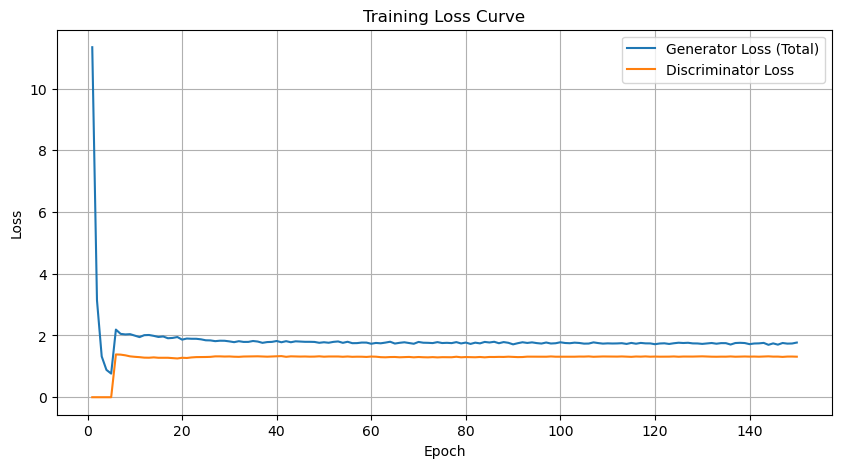

In [7]:
# ==========================================
# 6. 绘制并保存损失曲线
# ==========================================
epochs = len(history_loss_g)
if epochs == 0:
    print("未找到训练记录 (history_loss_g 为空)，请先运行训练循环。")
else:
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), history_loss_g, label='Generator Loss (Total)')
    plt.plot(range(1, epochs+1), history_loss_d, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig('saved_models/loss_curve.png')
    plt.show()